In [18]:
import os
import time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
#%matplotlib widget
import matplotlib
from PIL import Image
from progressbar import ProgressBar
from xml.dom import minidom
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset_utils import *

 10% (2 of 20) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

loading from:  ['./data/DJI ROCO/robomaster_Central China Regional Competition', './data/DJI ROCO/robomaster_Final Tournament', './data/DJI ROCO/robomaster_North China Regional Competition', './data/DJI ROCO/robomaster_South China Regional Competition']
10368 annotations, 10368 images found


100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


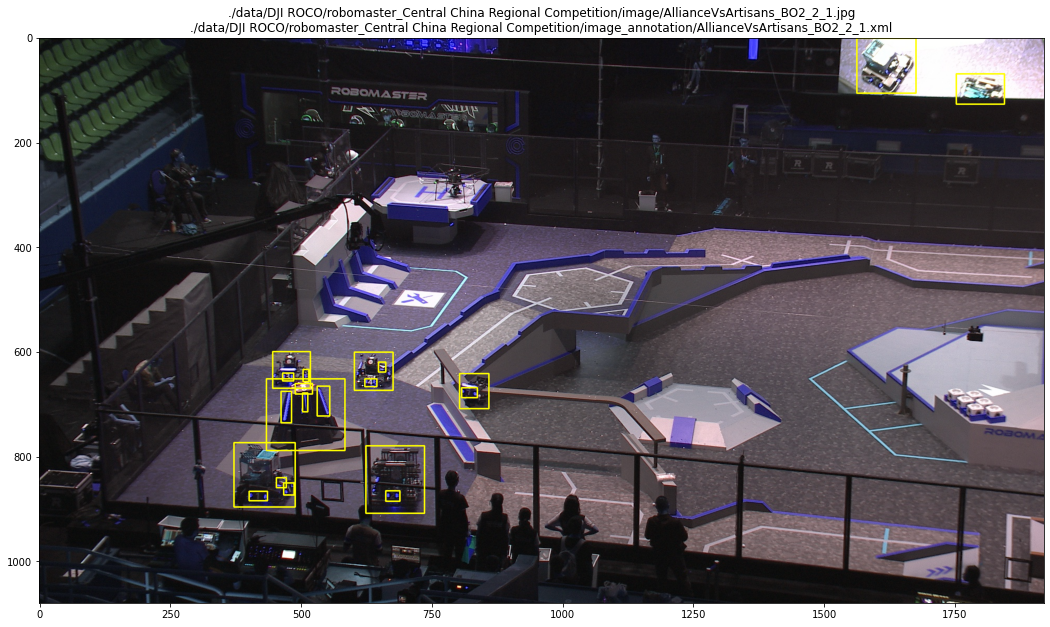

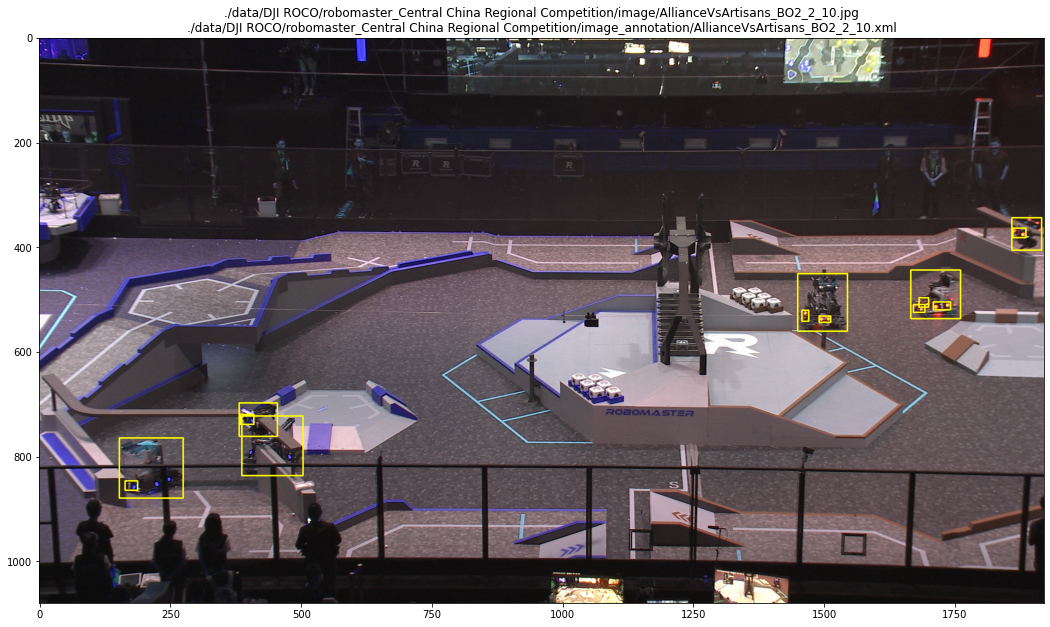

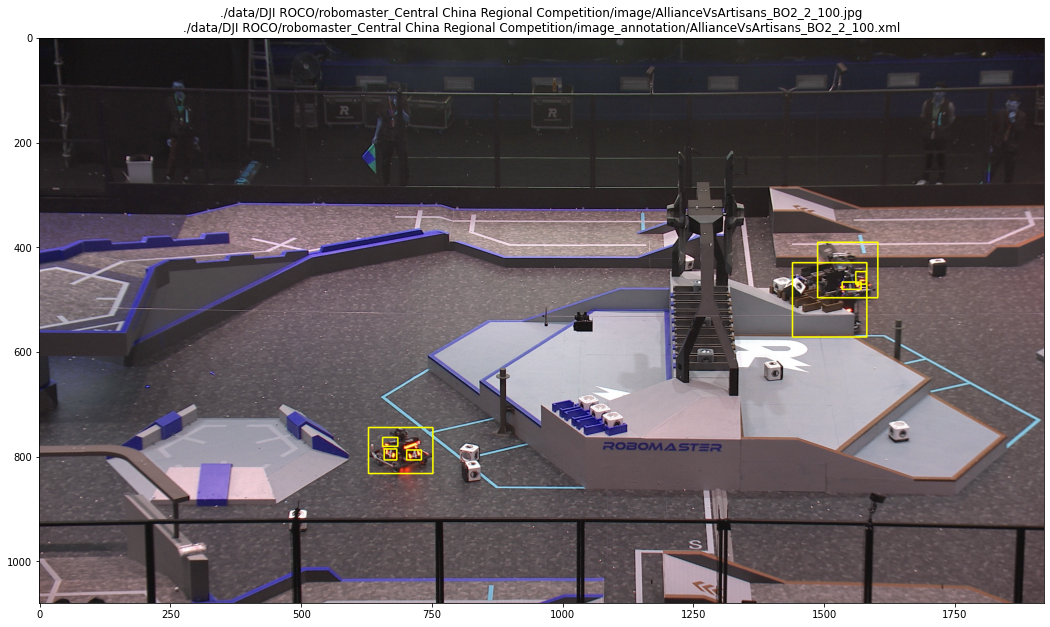

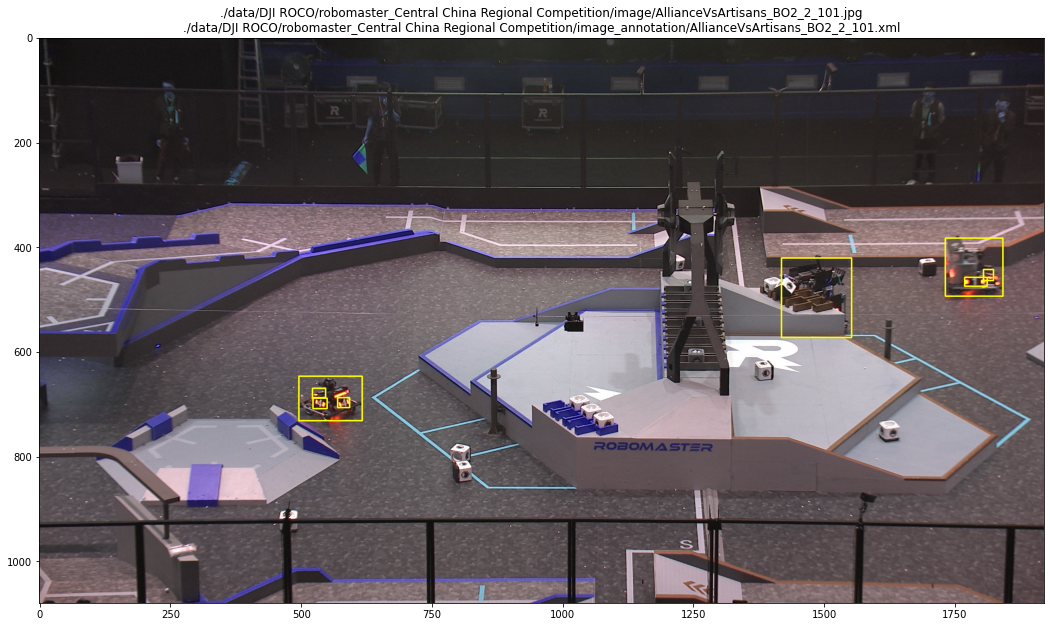

Error in callback <function flush_figures at 0x7f0da01f1430> (for post_execute):


KeyboardInterrupt: 

In [19]:
imgs, annots = load_dataset_from(num=20,plot=True)

Network Input Resolution:  [480 270]
{'zoom': 3, 'start': (820, 489)}
[{'name': 'armor', 'armor_class': 3, 'armor_color': 'red', 'bbmin': array([227.2125,   6.882 ]), 'bbmax': array([243.375,  19.239])}]


'Done'

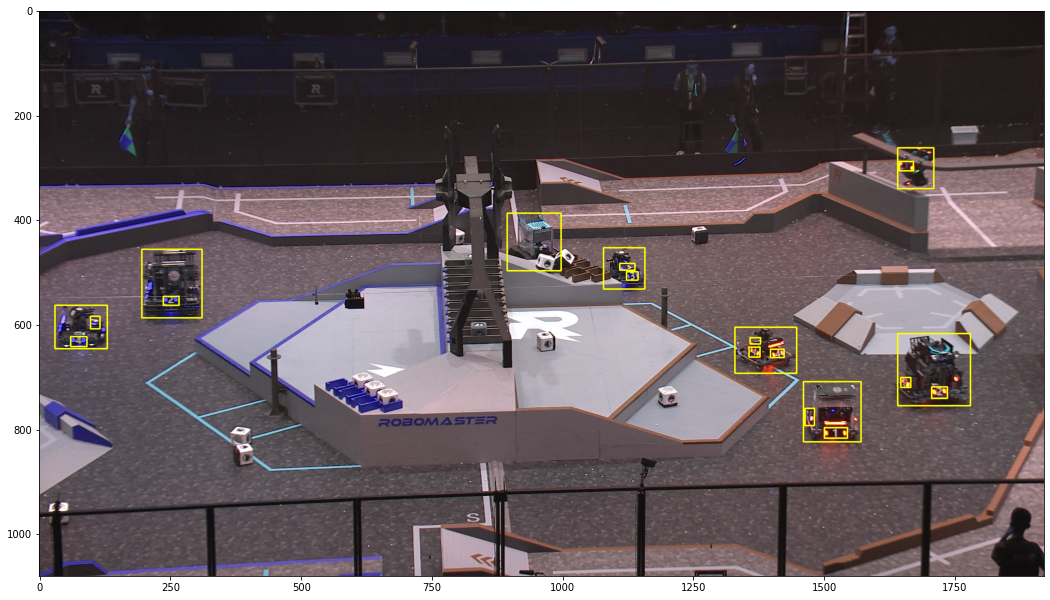

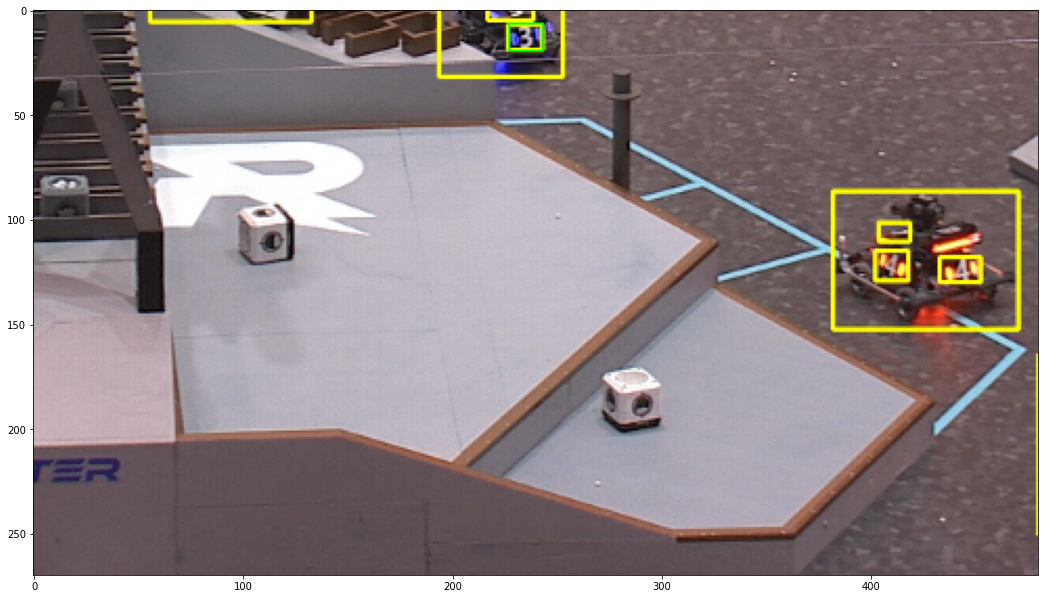

In [32]:
import copy

res = (np.array([1920,1080])/4).astype(int)
padding = [200,200] # part of image discarded
print('Network Input Resolution: ',res)
def get_random_spec():
    spec = dict()
    spec['zoom'] = np.random.uniform(1.5,4)
    spec['zoom'] = 3
    '''
        x->
       y|----------------------------------|
       l|                                  |
       v|  start(x,y)----------|           |
        |  |                   |           |
        |  |                   |           |
        |  --------------------|           |
        |                                  |
        |--------------------------------- |
    '''
    start_x = int(np.random.uniform(padding[0],1920-padding[0]-1920/spec['zoom']))
    start_y = int(np.random.uniform(padding[1],1080-padding[1]-1080/spec['zoom']))
    spec['start'] = (start_x,start_y)
    return spec
    
def multi_scale_crop(img,annot,allow_empty=True,plot=False):
    img = img.copy()
    annot = copy.deepcopy(annot)
    for i in range(1000):# Retry at most 100 times
        spec = get_random_spec()
        crop_x = [spec['start'][0],spec['start'][0]+int(1920/spec['zoom'])]
        crop_y = [spec['start'][1],spec['start'][1]+int(1080/spec['zoom'])]
        img_crop = img[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:].copy()
        img_crop = cv2.resize(img_crop, tuple(res))
        def shift_bb(o):
            o = copy.deepcopy(o)
            o['bbmin']-=np.array(spec['start'])
            o['bbmax']-=np.array(spec['start'])
            o['bbmin']/=res[0]/1080*spec['zoom']
            o['bbmax']/=res[0]/1080*spec['zoom']
            return o
        annot_crop = map(lambda o:shift_bb(o), annot)
        annot_crop = filter(lambda o: True
                       and 'armor' in o['name'] and COLOR in o['armor_color']
                       and np.sum(o['bbmin']<0)==0 and np.sum(o['bbmax']<0)==0
                       and o['bbmax'][1]<res[1]
                       and o['bbmax'][0]<res[0]
                       ,annot_crop)
        annot_crop=list(annot_crop)
        if allow_empty or ((not allow_empty) and len(annot_crop)!=0):
            break
    if plot:
        print(spec)
        print(annot_crop)
        for o in annot_crop:
            cv2.rectangle(img_crop,
                tuple(o['bbmin'].astype(int)), tuple(o['bbmax'].astype(int)),
                color=(0, 255, 0), thickness=1)
        plt.figure(figsize=(18,18))
        plt.imshow(img_crop)
    
    return img_crop, annot_crop
    
pair = imgs[19],annots[19]
plt.figure(figsize=(18,18))
plt.imshow(pair[0])
multi_scale_crop(pair[0],pair[1],plot=True,allow_empty=False)
'Done'

In [ ]:
def encode_object_to_vector(o,grid_center,): # Assume armor plate only
    vec = np.zeros([6]) #[w, h, dx, dy, w, color]
    